In [14]:
from datetime import datetime
import pandas as pd
import seaborn as sns
import numpy as np
import json
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, RobustScaler

from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE

from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline

from sklearn.metrics import confusion_matrix, classification_report

In [15]:
df = pd.read_csv('DS Challenge.csv', sep=';', encoding='utf8')

In [16]:
df.head()

,ID_USER,genero,monto,fecha,hora,dispositivo,establecimiento,ciudad,tipo_tc,linea_tc,interes_tc,status_txn,is_prime,dcto,cashback,fraude
0,0,F,"608,3456335",21/01/2020,20,{'model': 2020; 'device_score': 3; 'os': 'ANDR...,Super,Merida,FÃ­sica,71000,51,Aceptada,False,"60,83456335","5,475110702",False
1,0,F,"88,71924289",15/01/2020,7,{'model': 2020; 'device_score': 1; 'os': 'ANDR...,NaN,Merida,Virtual,71000,51,Aceptada,False,0,"1,774384858",False
2,1,F,"790,0376533",17/01/2020,11,"{'model': 2020; 'device_score': 1; 'os': ','}",NaN,Guadalajara,Virtual,94000,56,En proceso,False,0,"15,80075307",False
3,1,F,"767,0053873",5/01/2020,11,{'model': 2020; 'device_score': 3; 'os': 'WEB'},MPago,Guadalajara,FÃ­sica,94000,56,Aceptada,False,0,"7,670053873",False
4,1,F,"254,1710526",30/01/2020,10,{'model': 2020; 'device_score': 3; 'os': '%%'},NaN,Guadalajara,FÃ­sica,94000,56,Aceptada,False,0,"2,541710526",False


In [17]:
df['cashback'] = df['cashback'].str.replace(',', '.').astype(float)
df['monto'] = df['monto'].str.replace(',', '.').astype(float)
df['dcto'] = df['dcto'].str.replace(',', '.').astype(float)

# https://www.utf8-chartable.de/unicode-utf8-table.pl?start=128&number=128&utf8=string-literal&unicodeinhtml=hex
df['tipo_tc'] = df['tipo_tc'].str.replace('\xc3\xad','í').astype(str) 

df['date'] = df.apply(lambda row: datetime.strptime(str(row['fecha']) + ' ' + str(row['hora']) + ':00:00', '%d/%m/%Y %H:%M:%S').timestamp(), axis=1)
df['date'] = df['date'].astype('int64')

df['genero'] = df['genero'].replace('--', np.NaN)

In [18]:
def split_dispositivo_column(row):
    dispositivo = row['dispositivo'].replace(';', ',').replace('\'','\"')
    model = json.loads(dispositivo).get('model')
    score = json.loads(dispositivo).get('device_score')
    os = json.loads(dispositivo).get('os')
    os = 'unknown_category_1' if os == ',' else ('unknown_category_2' if os == '%%' else os)
    return pd.Series([model, score, os])
    
df[['dispositivo_model', 'dispositivo_puntaje', 'dispositivo_os']] = df.apply(split_dispositivo_column, axis = 1)

In [19]:
df.head()

,ID_USER,genero,monto,fecha,hora,dispositivo,establecimiento,ciudad,tipo_tc,linea_tc,interes_tc,status_txn,is_prime,dcto,cashback,fraude,date,dispositivo_model,dispositivo_puntaje,dispositivo_os
0,0,F,608.345633,21/01/2020,20,{'model': 2020; 'device_score': 3; 'os': 'ANDR...,Super,Merida,Física,71000,51,Aceptada,False,60.834563,5.475111,False,1579654800,2020,3,ANDROID
1,0,F,88.719243,15/01/2020,7,{'model': 2020; 'device_score': 1; 'os': 'ANDR...,NaN,Merida,Virtual,71000,51,Aceptada,False,0.000000,1.774385,False,1579089600,2020,1,ANDROID
2,1,F,790.037653,17/01/2020,11,"{'model': 2020; 'device_score': 1; 'os': ','}",NaN,Guadalajara,Virtual,94000,56,En proceso,False,0.000000,15.800753,False,1579276800,2020,1,unknown_category_1
3,1,F,767.005387,5/01/2020,11,{'model': 2020; 'device_score': 3; 'os': 'WEB'},MPago,Guadalajara,Física,94000,56,Aceptada,False,0.000000,7.670054,False,1578240000,2020,3,WEB
4,1,F,254.171053,30/01/2020,10,{'model': 2020; 'device_score': 3; 'os': '%%'},NaN,Guadalajara,Física,94000,56,Aceptada,False,0.000000,2.541711,False,1580396400,2020,3,unknown_category_2


In [20]:
# Sacando algunas columnas para categorizar usuarios que realizan transacciones con mayor revenue:
df_for_fraud = df.copy()

In [21]:
# No necesitamos estas columnas ya que en caso de fecha a hora fueron pasados a date, en caso de dispositivo se paso a 
# 3 categorias de la cual dispositivo_model solo presenta una categoria para todos los datos
df_for_fraud = df_for_fraud.drop(['ID_USER', 'fecha', 'hora', 'dispositivo', 'dispositivo_model'], axis=1)

In [22]:
# is prime y fraude son booleanos por lo que pasamos a 0 y 1
df_for_fraud['is_prime'] = df_for_fraud['is_prime'].astype(int)
df_for_fraud['fraude'] = df_for_fraud['fraude'].astype(int)

In [23]:
df_for_fraud.head()

,genero,monto,establecimiento,ciudad,tipo_tc,linea_tc,interes_tc,status_txn,is_prime,dcto,cashback,fraude,date,dispositivo_puntaje,dispositivo_os
0,F,608.345633,Super,Merida,Física,71000,51,Aceptada,0,60.834563,5.475111,0,1579654800,3,ANDROID
1,F,88.719243,NaN,Merida,Virtual,71000,51,Aceptada,0,0.000000,1.774385,0,1579089600,1,ANDROID
2,F,790.037653,NaN,Guadalajara,Virtual,94000,56,En proceso,0,0.000000,15.800753,0,1579276800,1,unknown_category_1
3,F,767.005387,MPago,Guadalajara,Física,94000,56,Aceptada,0,0.000000,7.670054,0,1578240000,3,WEB
4,F,254.171053,NaN,Guadalajara,Física,94000,56,Aceptada,0,0.000000,2.541711,0,1580396400,3,unknown_category_2


In [24]:
std_scaler = StandardScaler() # no outliers para monto y date
rob_scaler = RobustScaler() # robusto cuando hay outliers : como dcto y cashback (como vimos en EDA.ipynb)


df_for_fraud['monto'] = std_scaler.fit_transform(df_for_fraud['monto'].values.reshape(-1,1))
df_for_fraud['date'] = std_scaler.fit_transform(df_for_fraud['date'].values.reshape(-1,1))

df_for_fraud['dcto'] = rob_scaler.fit_transform(df_for_fraud['dcto'].values.reshape(-1,1))
df_for_fraud['cashback'] = rob_scaler.fit_transform(df_for_fraud['cashback'].values.reshape(-1,1))

In [25]:
df_for_fraud.head()

,genero,monto,establecimiento,ciudad,tipo_tc,linea_tc,interes_tc,status_txn,is_prime,dcto,cashback,fraude,date,dispositivo_puntaje,dispositivo_os
0,F,0.377721,Super,Merida,Física,71000,51,Aceptada,0,3.24093,-0.028154,0,0.630889,3,ANDROID
1,F,-1.418404,NaN,Merida,Virtual,71000,51,Aceptada,0,0.00000,-0.672895,0,-0.149276,1,ANDROID
2,F,1.005752,NaN,Guadalajara,Virtual,94000,56,En proceso,0,0.00000,1.770781,0,0.109123,1,unknown_category_1
3,F,0.926139,MPago,Guadalajara,Física,94000,56,Aceptada,0,0.00000,0.354249,0,-1.322007,3,WEB
4,F,-0.846509,NaN,Guadalajara,Física,94000,56,Aceptada,0,0.00000,-0.539211,0,1.654545,3,unknown_category_2


### Pasando a dummies variables

In [26]:
cat_vars=['genero', 'establecimiento','ciudad','tipo_tc','linea_tc','interes_tc','status_txn', 'dispositivo_puntaje', 'dispositivo_os']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(df_for_fraud[var], prefix=var)
    data_temp=df_for_fraud.join(cat_list)
    df_for_fraud=data_temp
    
data_vars=df_for_fraud.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]

data_fraud_final=df_for_fraud[to_keep]

#### SMOTE algorithm

Debido a que tenemos muy pocas transacciones como fraude debemos balancear nuestra data,
haremos oversampling con el algorithmo smote.

Antes, debemps partir la data para data de entrenamiento y prueba (test)

In [27]:
print('No Frauds', round(data_fraud_final['fraude'].value_counts()[0]/len(data_fraud_final) * 100,2), '% of the dataset')
print('Frauds', round(data_fraud_final['fraude'].value_counts()[1]/len(data_fraud_final) * 100,2), '% of the dataset')

X = data_fraud_final.drop('fraude', axis=1)
y = data_fraud_final['fraude']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]



# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

No Frauds 97.0 % of the dataset
Frauds 3.0 % of the dataset
Train: [ 4836  4883  4932 ... 26972 26973 26974] Test: [   0    1    2 ... 5412 5413 5414]
Train: [    0     1     2 ... 26972 26973 26974] Test: [ 4836  4883  4932 ... 10806 10807 10808]
Train: [    0     1     2 ... 26972 26973 26974] Test: [10201 10231 10284 ... 16196 16197 16198]
Train: [    0     1     2 ... 26972 26973 26974] Test: [15662 15694 15717 ... 21592 21593 21594]
Train: [    0     1     2 ... 21592 21593 21594] Test: [20759 20888 20895 ... 26972 26973 26974]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.9699722 0.0300278]
[0.9699722 0.0300278]


In [28]:
# SMOTE algorithm (OverSampling) After splitting and Cross Validating
sm = SMOTE(sampling_strategy='minority', random_state=42)


# This will be the data were we are going to 
Xsm_train, ysm_train = sm.fit_resample(original_Xtrain, original_ytrain)

In [29]:
# Logistic Regression 
log_reg_params = {"penalty": ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

In [81]:
grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(Xsm_train, ysm_train)

C:\Users\Nilton\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Nilton\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l2']})

In [84]:
y_pred_log_reg = grid_log_reg.predict(original_Xtest)
oversample_score_lr = accuracy_score(original_ytest, y_pred_log_reg)

In [92]:
print('Accuracy of ' + str(round(oversample_score_lr*100,2)) + '%')

Accuracy of 58.76%


### Matriz de confusion

Text(0.5, 1.0, 'Logistic Regression \n Confusion Matrix')

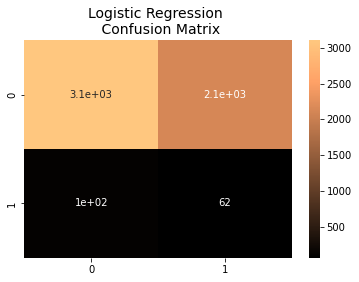

In [98]:
log_reg_cf = confusion_matrix(original_ytest, y_pred_log_reg)
sns.heatmap(log_reg_cf, annot=True, cmap=plt.cm.copper)
plt.title("Logistic Regression \n Confusion Matrix", fontsize=14)

Segun observamos en la matriz de confusion:
  - En reconocer fraudes estamos aún cortos
  - El reconocimiento de no fraudes es relativamente buena

In [100]:
print('Logistic Regression:')
print(classification_report(original_ytest, y_pred_log_reg))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.97      0.59      0.74      5233
           1       0.03      0.38      0.05       162

    accuracy                           0.59      5395
   macro avg       0.50      0.49      0.39      5395
weighted avg       0.94      0.59      0.72      5395



Lo mismo que habiamos observado sobre la deteccion de fraude en la matriz de confusion se ve aterrizada en números en el report de arriba:
  - Precision para no fraude mucho mejor que para fraude
  - Recall para no fraude mucho mejor que para fraude
  - f1-score para no fraude mucho mejor que para fraude

### Tradeoff

Si bien es cierto podriamos tener un modelo 'ingenuo' que clasifique a todas las transacciones como no fraude y obtener una precision más alta que la que tenemos (59% approx.) sin embargo, en el caso de detectar lo que si son fraudes obtendriamos ligera ventaja con el modelo ingenuo y justamente es esto lo que se busca en este tipo de problemas.

#### Guardamos el modelo

In [89]:
import pickle

pickle.dump(grid_log_reg, open('modelo_final.sav', 'wb'))